# Collaborative Filtering Memory Based

Collaborative filtering leverages the power of the crowd. The intuition behind collaborative filtering is that if a user A likes products X and Y, and if another user B likes product X, there is a fair bit of chance that he will like the product Y also.

## Movie Recommender System Implementation in Python

In this section, we'll develop a very simple movie recommender system in Python that uses the correlation between the ratings assigned to different movies, in order to find the similarity between the movies.

In [46]:
import numpy as np
import pandas as pd

ratings_data = pd.read_csv("./res/data/imdb/ratings.csv")
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


You can see from the output that the `ratings.csv` file contains the `userId`, `movieId`, `ratings`, and `timestamp attributes`. Each row in the dataset corresponds to one rating. The `userId` column contains the ID of the user who left the rating. The `movieId` column contains the Id of the movie, the `rating` column contains the rating left by the user. Ratings can have values between `1` and `5`. And finally, the `timestamp` refers to the time at which the user left the rating.

There is one problem with this dataset. **_It contains the IDs of the movies but not their titles_**. We'll need `movie names` for the movies we're recommending. The `movie names` are stored in the "movies.csv" file. Let's import the file and see the data it contains.

In [47]:
ratings_data['movieId'].max()

176275

In [48]:
movie_names = pd.read_csv("./res/data/imdb/movies.csv")
movie_names.isnull().sum()

/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_16112/1062477765.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_names = pd.read_csv("./res/data/imdb/movies.csv")


adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [49]:
# remove movies with no release dates specified
movie_names = movie_names[~movie_names['release_date'].isnull()]

In [50]:
import re
for i,row in movie_names.iterrows():
    if re.search(r"\d\d\d\d-\d\d-\d\d", row['id']):
        print(i)

19730
29503
35587


In [51]:
# convert release dates into datetime values and reset index for the rows dropped
# also convert the ids into integers for merge later, and drop any ids that are dates
movie_names['release_date'] = pd.to_datetime(movie_names['release_date'], errors='coerce')
movie_names['id'] = movie_names['id'].drop(index=[19730, 29503, 35587])
movie_names = movie_names[~movie_names['id'].isnull()]
movie_names['id'] = movie_names['id'].astype('int')
movie_names.reset_index(inplace=True)
movie_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45376 entries, 0 to 45375
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  45376 non-null  int64         
 1   adult                  45376 non-null  object        
 2   belongs_to_collection  4488 non-null   object        
 3   budget                 45376 non-null  object        
 4   genres                 45376 non-null  object        
 5   homepage               7766 non-null   object        
 6   id                     45376 non-null  int64         
 7   imdb_id                45362 non-null  object        
 8   original_language      45365 non-null  object        
 9   original_title         45376 non-null  object        
 10  overview               44435 non-null  object        
 11  popularity             45376 non-null  object        
 12  poster_path            45037 non-null  object        
 13  p

/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_16112/3344117065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_names['release_date'] = pd.to_datetime(movie_names['release_date'], errors='coerce')
/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_16112/3344117065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_names['id'] = movie_names['id'].drop(index=[19730, 29503, 35587])
/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_16112/3344117065.py:6: SettingWith

In [52]:
# create new columns for year, month, and day
for i, time in movie_names['release_date'].items():
    movie_names.loc[i, 'year'] = time.year
    movie_names.loc[i, 'month'] = time.month
    movie_names.loc[i, 'day'] = time.day

In [53]:
# use abstact syntax tree
import ast

# the genres columns was formatted as a list of dictionaries but as a string
# ast helps us convert the string format into the list and dict types so we can work with it
genres = {}
for row in range(len(movie_names['genres'])):
    genre_list = []
    genres_info = ast.literal_eval(movie_names.loc[row, 'genres'])
    for genre in genres_info:
        genre_list.append(genre['name'])
    
    results = '|'.join(genre_list)
    genres[f"{movie_names.loc[row, 'original_title']} ({movie_names.loc[row, 'year']:.0f})"] = results

In [54]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [55]:
movie_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45376 entries, 0 to 45375
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  45376 non-null  int64         
 1   adult                  45376 non-null  object        
 2   belongs_to_collection  4488 non-null   object        
 3   budget                 45376 non-null  object        
 4   genres                 45376 non-null  object        
 5   homepage               7766 non-null   object        
 6   id                     45376 non-null  int64         
 7   imdb_id                45362 non-null  object        
 8   original_language      45365 non-null  object        
 9   original_title         45376 non-null  object        
 10  overview               44435 non-null  object        
 11  popularity             45376 non-null  object        
 12  poster_path            45037 non-null  object        
 13  p

In [56]:
df_genres = pd.DataFrame(genres.values(), genres.keys()).reset_index()
df_genres.rename({'index':'title', 0:'genres'}, axis=1, inplace=True)
df_genres['id'] = movie_names['id']

In [57]:
movie_data = pd.merge(ratings_data, df_genres, left_on='movieId', right_on='id')

In [58]:
movie_data.shape

(11429745, 7)

In [64]:
movie_data.groupby('title')['rating'].mean().head()

title
$5 a Day (2008)                            3.431818
$ellebrity (2013)                          2.683409
'Twas the Night Before Christmas (1974)    3.250000
(A)Sexual (2011)                           2.685542
009 RE：CYBORG (2012)                       3.343228
Name: rating, dtype: float64

You can see that the average ratings are not sorted. Let's sort the ratings in the descending order of their average ratings.

In [63]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Conversations with God (2006)    5.0
Break Free (2014)                5.0
Bridgend (2015)                  5.0
Clambake (1967)                  5.0
Restraint (2008)                 5.0
Name: rating, dtype: float64

The movies have now been sorted according to the ascending order of their ratings. However, there is a problem. A movie can make it to the top of the above list even if only a single user has given it five stars. Therefore, the above stats can be misleading. Normally, a movie which is really a good one gets a higher rating by a large number of users.

In [65]:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Krampack (2000)         91082
Swimming Pool (2003)    87901
Network (1976)          84078
The 39 Steps (1935)     77045
Wendigo (2001)          74355
Name: rating, dtype: int64

Now you can see some really good movies at the top. The above list supports our point that good movies normally receive higher ratings. Now we know that both the average rating per movie and the number of ratings per movie are important attributes. Let's create a new dataframe that contains both of these attributes.

In [72]:
movie_data[movie_data['title'] == 'Krampack (2000)'].groupby('title')['rating'].mean()

title
Krampack (2000)    4.429015
Name: rating, dtype: float64

In [76]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
title,,
$5 a Day (2008),3.431818,66
$ellebrity (2013),2.683409,657
'Twas the Night Before Christmas (1974),3.250000,2
(A)Sexual (2011),2.685542,11558
009 RE：CYBORG (2012),3.343228,539


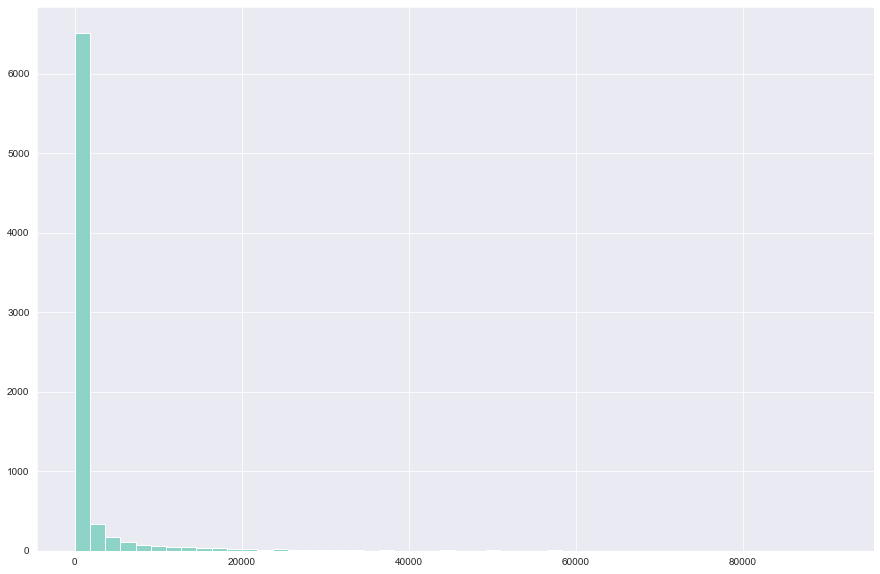

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(15,10))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)
plt.show()

From the output, you can see that most of the movies have received less than 50 ratings. While the number of movies having more than 100 ratings is very low.

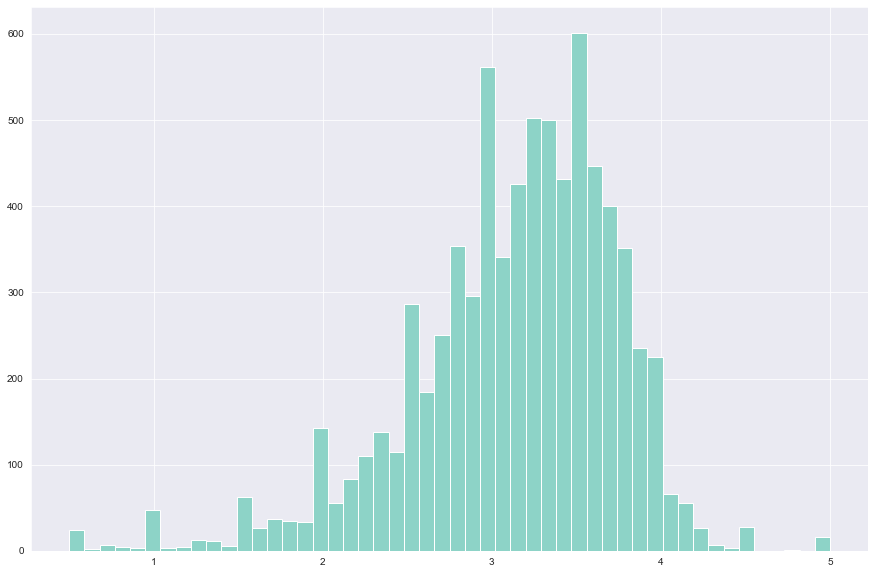

In [81]:
plt.figure(figsize=(15,10))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)
plt.show()

You can see that the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 or 5. Furthermore, it is evident that the data has a weak normal distribution with the mean of around 3.5. There are a few outliers in the data.

Earlier, we said that movies with a higher number of ratings usually have a high average rating as well since a good movie is normally well-known and a well-known movie is watched by a large number of people, and thus usually has a higher rating. Let's see if this is also the case with the movies in our dataset. We will plot average ratings against the number of ratings:

<Figure size 1080x720 with 0 Axes>

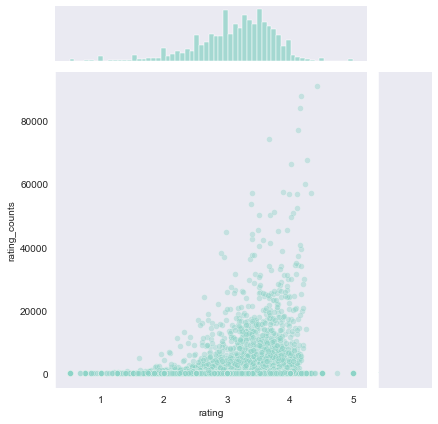

In [87]:
plt.figure(figsize=(15,10))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)
plt.show()

The graph shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

### Finding Similarities Between Movies

We spent quite a bit of time on visualizing and preprocessing our data. Now is the time to find the similarity between movies.

We will use the correlation between the ratings of a movie as the similarity metric. To find the correlation between the ratings of the movie, we need to create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie. Bear in mind that this matrix will have a lot of null values since every movie is not rated by every user.

In [88]:
user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()

title,$5 a Day (2008),$ellebrity (2013),'Twas the Night Before Christmas (1974),(A)Sexual (2011),009 RE：CYBORG (2012),1 Mile to You (2017),1 P.M. (1972),1. Mai – Helden bei der Arbeit (2008),10 Days in a Madhouse (2015),10 Milliarden - Wie werden wir alle satt? (2015),...,평양성 (2011),폰 (2002),해안선 (2002),헨젤과 그레텔 (2007),혈의 누 (2005),홍길동의 후예 (2009),황제를 위하여 (2014),회사원 (2012),후궁: 제왕의 첩 (2012),ＳＭガールズ セイバーマリオネットＲ (1995)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We know that each column contains all the user ratings for a particular movie. Let's find all the user ratings for the movie "Forrest Gump (1994)" and find the movies similar to it. We chose this movie since it has the highest number of ratings and we want to find the correlation between movies that have a higher number of ratings.

In [90]:
forrest_gump_ratings = user_movie_rating['Forrest Gump (1994)']
forrest_gump_ratings.head()

userId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: Forrest Gump (1994), dtype: float64

In [91]:
movies_like_forest_gump = user_movie_rating.corrwith(forrest_gump_ratings)

corr_forrest_gump = pd.DataFrame(movies_like_forest_gump, columns=['Correlation'])
corr_forrest_gump.dropna(inplace=True)
corr_forrest_gump.head()

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
$5 a Day (2008),-0.484248
$ellebrity (2013),0.454939
(A)Sexual (2011),0.445568
009 RE：CYBORG (2012),0.373314
1 Mile to You (2017),-0.337978


In the above script, we first retrieved the list of all the movies related to "Forrest Gump (1994)" along with their correlation value, using corrwith() function. Next, we created a dataframe that contains movie title and correlation columns. We then removed all the NA values from the dataframe and displayed its first 5 rows using the head function.

In [92]:
corr_forrest_gump.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
"Paris, Texas (1984)",1.0
Krull (1983),1.0
Great Expectations (1998),1.0
L.A. Confidential (1997),1.0
Wanda (1970),1.0
Vérités et Mensonges (1973),1.0
Violette (2013),1.0
Band of Brothers (2001),1.0
L'Art de la fugue (2015),1.0


From the output you can see that the movies that have high correlation with "Forrest Gump (1994)" are not very well known. This shows that correlation alone is not a good metric for similarity because there can be a user who watched '"Forest Gump (1994)" and only one other movie and rated both of them as 5.

A solution to this problem is to retrieve only those correlated movies that have at least more than 50 ratings. To do so, will add the rating_counts column from the rating_mean_count dataframe to our corr_forrest_gump dataframe.

In [93]:
corr_forrest_gump = corr_forrest_gump.join(ratings_mean_count['rating_counts'])
corr_forrest_gump.head()

,Correlation,rating_counts
title,,
$5 a Day (2008),-0.484248,66
$ellebrity (2013),0.454939,657
(A)Sexual (2011),0.445568,11558
009 RE：CYBORG (2012),0.373314,539
1 Mile to You (2017),-0.337978,148


You can see that the movie "$9.99", which has the highest correlation has only three ratings. This means that only three users gave same ratings to "Forest Gump (1994)", "$9.99". However, we can deduce that a movie cannot be declared similar to the another movie based on just 3 ratings. This is why we added "rating_counts" column. Let's now filter movies correlated to "Forest Gump (1994)", that have more than 50 ratings.

In [94]:
corr_forrest_gump[corr_forrest_gump ['rating_counts']>50].sort_values('Correlation', ascending=False).head()

,Correlation,rating_counts
title,,
Forrest Gump (1994),1.0,1838
Os Penetras (2012),1.0,85
The Last Winter (2006),1.0,52
Why We Fight: Prelude to War (1942),1.0,145
Radical Grace (2015),1.0,71


Now you can see from the output the movies that are highly correlated with "Forrest Gump (1994)". The movies in the list are some of the most famous movies Hollywood movies, and since "Forest Gump (1994)" is also a very famous movie, there is a high chance that these movies are correlated.